In [1]:
import pandas as pd
import graphviz
from typing import Callable

**Expected preferences:**
1. Path of Exile > Last Epoch \
    Two action roleplaying games, the first being significantly more established.

2. Divinity Original Sin 2 > Gears Tactics \
    Both are (comparatively) recent and not cheap but Gears Tactics saw barely any success (and was added to the wishlist before its release, while one of the author was really looking forward to trying it after beating XCOM 2) vs. another game revolving around turn-based combat, which just happens to be  one of the best received CRPGs ever.

3. Portal 2 > Superliminal \
    The most iconic puzzle game ever is definitely expected to beat any competitor that targets a niche so similar.

4. Slay the Spite > Rogue Legacy 2 \
    Despite both of these being roguelikes, suggesting that Rogue Legacy 2 might be at an advantage, the person writing these words sunk over 500 hours into Slay the Spire and doesn't regret a single one.


## PROMETHEE

In [2]:
alternatives = pd.read_csv("./data/games.csv")
criteria = pd.read_csv("./data/games_criteria.csv")

In [3]:
alternatives

,title,price,positive_reviews_percentage,number_of_reviews,system_requirements,content_volume,gameplay,audio,graphics,wishlist_position
0,Nebuchadnezzar,71.99,81,1085,3,5,8,6,6,1
1,Baba Is You,53.99,98,14974,1,8,7,3,4,2
2,ELDEN RING,249.00,92,494145,9,10,8,8,8,3
3,FTL Faster Than Light,35.99,95,52971,1,6,7,9,4,4
4,Superliminal,71.99,94,18197,4,4,6,3,5,5
5,Rogue Legacy 2,114.99,90,11809,3,6,6,5,6,6
6,Last Epoch,161.99,84,15629,7,9,9,6,7,7
7,Gears Tactics,142.99,75,5873,8,5,5,4,7,8
8,Path of Exile,0.00,87,197422,7,11,8,6,7,0
9,Divinity Original Sin 2,161.99,95,139068,7,9,9,9,9,0


In [4]:
criteria

,criterion_name,criterion_type,indifference,preference,veto,weight
0,price,cost,10,20,50.0,7
1,positive_reviews_percentage,gain,5,10,40.0,10
2,number_of_reviews,gain,100,10000,100000.0,5
3,system_requirements,cost,1,3,7.0,6
4,content_volume,gain,1,4,6.0,6
5,gameplay,gain,2,5,7.0,8
6,audio,gain,3,7,NaN,3
7,graphics,gain,2,5,NaN,4
8,wishlist_position,cost,0,3,50.0,6


In [5]:
from validate_input import validate_input
validate_input(alternatives, criteria)

True

In [6]:
print(criteria.iloc[0])

criterion_name    price
criterion_type     cost
indifference         10
preference           20
veto               50.0
weight                7
Name: 0, dtype: object


In [7]:
# compute preference between alternatives a and b
def marginal_preference_index(a: pd.Series, b: pd.Series, criterion: pd.Series) -> float:
    p = criterion["preference"]
    q = criterion["indifference"]
    criterion_type = criterion["criterion_type"]
    criterion_name = criterion["criterion_name"]
    a_val = a[criterion_name]
    b_val = b[criterion_name]
    difference = a_val - b_val
    if criterion_type == "cost":
        difference *= -1

    if difference > p:
        return 1
    if difference <= q:
        return 0
    return (difference - q) / (p-q)

In [8]:
def comprehensive_preference_index(a: pd.Series, b: pd.Series, criteria: pd.DataFrame) -> float:
    numerator_sum = sum([marginal_preference_index(a, b, criterion[1])*criterion[1]["weight"] for criterion in criteria.iterrows()])
    sum_of_weights = sum([criterion[1]["weight"] for criterion in criteria.iterrows()])
    return numerator_sum/sum_of_weights

In [9]:
def positive_flow(alternative: pd.Series, alternatives: pd.DataFrame, criteria: pd.DataFrame) -> float:
    flow = 0
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue
        flow += comprehensive_preference_index(alternative[1], b_alternative[1], criteria)
    return flow

def negative_flow(alternative, alternatives, criteria):
    flow = 0
    for b_alternative in alternatives.iterrows():
        if alternative[0] == b_alternative[0]:
            continue
        flow += comprehensive_preference_index(b_alternative[1], alternative[1], criteria)
    return flow

In [10]:
for alternative in alternatives.iterrows():
    print(alternative[1][0],
          positive_flow(alternative, alternatives, criteria),
          negative_flow(alternative, alternatives, criteria))

Nebuchadnezzar 2.241212121212121 5.164563820018366
Baba Is You 3.956859504132231 2.3768044077134984
ELDEN RING 3.7242424242424246 4.109090909090909
FTL Faster Than Light 3.7942424242424244 2.593939393939394
Superliminal 2.459384756657484 4.629090909090909
Rogue Legacy 2 1.81722681359045 4.7079247015610655
Last Epoch 1.903682277318641 6.550844811753903
Gears Tactics 0.5206244260789715 8.646124885215794
Path of Exile 5.129872727272727 2.7954545454545454
Divinity Original Sin 2 4.1863636363636365 3.1872727272727266
Terraria 5.453333333333332 0.43636363636363634
Slay the Spire 4.090909090909091 2.0718181818181822
Geometry Dash 4.9818181818181815 2.493509090909091
Bloons TD 6 4.254545454545454 2.0757575757575757
Portal 2 4.657575757575758 1.3333333333333333


In [11]:
def PROMETHEE1_relations_dict(alternatives: pd.DataFrame, criteria: pd.DataFrame) -> dict:
    alternative_names = alternatives.iloc[:, 0].tolist()
    # determining relations between all pairs of alternatives based on positive and negative flows
    positive_flow_dict = dict((a[1][0], positive_flow(a, alternatives, criteria))
                               for a in alternatives.iterrows())
    negative_flow_dict = dict((a[1][0], negative_flow(a, alternatives, criteria))
                               for a in alternatives.iterrows())
    relations_dict = dict()
    for name in alternative_names:
        for different_name in alternative_names:
            if name == different_name:
                continue
            if ((positive_flow_dict[name] >= positive_flow_dict[different_name] and
                negative_flow_dict[name] < negative_flow_dict[different_name]) or
               (positive_flow_dict[name] > positive_flow_dict[different_name] and
                negative_flow_dict[name] <= negative_flow_dict[different_name])):
                relations_dict[(name, different_name)] = 'P'
            elif (positive_flow_dict[name] == positive_flow_dict[different_name] and
                  negative_flow_dict[name] == negative_flow_dict[different_name]):
                relations_dict[((name, different_name))] = 'I'
            elif ((positive_flow_dict[name] > positive_flow_dict[different_name] and
                negative_flow_dict[name] > negative_flow_dict[different_name]) or
               (positive_flow_dict[name] < positive_flow_dict[different_name] and
                negative_flow_dict[name] < negative_flow_dict[different_name])):
                relations_dict[(name, different_name)] = '?'
    return relations_dict

In [12]:
def pairwise_dict_to_df(d: dict) -> pd.DataFrame:
        # extract the names of all elements\n",
        names = set()
        for a, b in d.keys():
            names.add(a)
            names.add(b)
        names = list(names)
        df = pd.DataFrame(columns = names, index=names)
        for key, value in d.items():
            # this way, relations are formed \"from row to column\"\n",
            # e. g. if in row a, column b has value \"P\", the relation aPb holds
            df[key[1]][key[0]] = value
        return df

In [13]:
pairwise_dict_to_df(PROMETHEE1_relations_dict(alternatives, criteria))

,Baba Is You,Slay the Spire,Bloons TD 6,Portal 2,ELDEN RING,Path of Exile,Last Epoch,Geometry Dash,Nebuchadnezzar,Gears Tactics,Rogue Legacy 2,Divinity Original Sin 2,Superliminal,Terraria,FTL Faster Than Light
Baba Is You,NaN,NaN,NaN,NaN,P,?,P,?,P,P,P,?,P,NaN,P
Slay the Spire,P,NaN,?,NaN,P,?,P,?,P,P,P,?,P,NaN,P
Bloons TD 6,P,?,NaN,NaN,P,?,P,?,P,P,P,P,P,NaN,P
Portal 2,P,P,P,NaN,P,?,P,?,P,P,P,P,P,NaN,P
ELDEN RING,NaN,NaN,NaN,NaN,NaN,NaN,P,NaN,P,P,P,NaN,P,NaN,NaN
Path of Exile,?,?,?,?,P,NaN,P,?,P,P,P,P,P,NaN,?
Last Epoch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,?,NaN,NaN,NaN,NaN
Geometry Dash,?,?,?,?,P,?,P,NaN,P,P,P,P,P,NaN,P
Nebuchadnezzar,NaN,NaN,NaN,NaN,NaN,NaN,P,NaN,NaN,P,?,NaN,NaN,NaN,NaN
Gears Tactics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def incomplete_ranking_to_graph(ranking: list, relations_dict: dict) -> graphviz.Digraph:
    # to differentiate between incomparability and indifference
    def group_alternatives_in_ranking(ranking: list, relations_dict: dict) -> list:
        grouped_ranking = []
        for level in ranking:
            # all alternatives on the same level are either PAIRWISE indifferent or incomparable
            # alternatives within a level are divided into groups of indifferent alternatives
            # the alternatives in different groups are incomparable to each other
            if len(level) == 1:
                grouped_ranking.append([level])
                continue
            ungrouped_alternatives = level[1:]
            current_group = [level[0]]
            grouped_alternatives = []
            while ungrouped_alternatives:
                alternatives_to_group = []
                for alternative in ungrouped_alternatives:
                    if current_group[0] == alternative:
                        continue
                    if relations_dict[(current_group[0], alternative)] == "I":
                        current_group.append(alternative)
                        alternatives_to_group.append(alternative)
                grouped_alternatives.append(current_group)
                for alternative in alternatives_to_group:
                    ungrouped_alternatives.remove(alternative)
                current_group = []
                if ungrouped_alternatives:
                    current_group = [ungrouped_alternatives[0]]
                    ungrouped_alternatives.remove(ungrouped_alternatives[0])
            if current_group:
                grouped_alternatives.append(current_group)
            grouped_ranking.append(grouped_alternatives)
        return grouped_ranking


    # to make main loop more readable
    def model_group_outranking(parent_group: list, group: list, graphed_winners_dict: dict, graphed_losers_dict: dict, ranking_graph: graphviz.Digraph) -> None:
        if relations_dict[(parent_group[0], group[0])] == "P":
                    ranking_graph.edge(', '.join(parent_group), ', '.join(group))
                    for parent_a in parent_group:
                        for child_a in group:
                            graphed_winners_dict[parent_a].add(child_a)
                            graphed_losers_dict[child_a].add(parent_a)
                            # add child to all that outrank it - modeling "transitive outranking" 
                            for ancestor in graphed_losers_dict[parent_a]:
                                graphed_winners_dict[ancestor].add(child_a)
                                graphed_losers_dict[child_a].add(ancestor)

    # key: alternative, value: group it belongs to
    def create_group_dict(grouped_ranking: list) -> dict:
        group_dict = dict()
        for level in grouped_ranking:
            for group in level:
                for alternative in group:
                    group_dict[alternative] = group
        return group_dict


    grouped_ranking = group_alternatives_in_ranking(ranking, relations_dict)
    group_dict = create_group_dict(grouped_ranking)
    ranking_graph = graphviz.Digraph(comment="PROMETHEE I ranking")
    # add the top level to the graph
    for group in grouped_ranking[0]:
        node_label = ', '.join(group)
        ranking_graph.node(node_label, node_label)
    previous_level = grouped_ranking[0]
    graphed_winners_dict = dict([(a, set()) for level in ranking for a in level])
    graphed_losers_dict = dict([(a, set()) for level in ranking for a in level])

    # for lower levels, add connection from appropriate groups in levels directly above
    for level in grouped_ranking[1:]:
        for group in level:
            for parent_group in previous_level:
                model_group_outranking(parent_group, group, graphed_winners_dict, graphed_losers_dict, ranking_graph)
        previous_level = level

    # check that all preferences have been included in the graph
    # if not - draw necessary arcs
    # must start at the lowest level

    preference_winners_dict = dict([(a, []) for level in ranking for a in level])
    preference_losers_dict = dict([(a, []) for level in ranking for a in level])
    for pair, relation in relations_dict.items():
        if relation != "P":
            continue
        preference_winners_dict[pair[0]].append(pair[1])
        preference_losers_dict[pair[1]].append(pair[0])

    for level in grouped_ranking:
        for group in level:
            for alternative in group:
                for outranker in preference_losers_dict[alternative]:
                    if outranker not in graphed_losers_dict[alternative]:
                        outranker_group = group_dict[outranker]
                        outranked_group = group_dict[alternative]
                        ranking_graph.edge(', '.join(outranker_group), ', '.join(group))
                        for a in outranker_group:
                            graphed_losers_dict[alternative].add(a)
                            graphed_winners_dict[a].add(alternative)
                            for b in outranked_group:
                                graphed_winners_dict[a].add(b)
                                graphed_losers_dict[b].add(a)
                                for c in preference_winners_dict[b]:
                                    graphed_winners_dict[a].add(c)
                                    graphed_losers_dict[c].add(a)

    return ranking_graph

In [15]:
def PROMETHEE1_ranking(alternatives: pd.DataFrame, criteria: pd.DataFrame):
    
    alternative_names = alternatives.iloc[:, 0].tolist()
    relations_dict = PROMETHEE1_relations_dict(alternatives, criteria)
    

    # key: alternative; value: list of all alternatives preferred to it
    # the outranking alternatives are removed step-by-step as the ranking is built from top to bottom
    # e. g. a dictionary: {a: [], b: [a], c: [a, b]} represents the ranking: a>b>c
    # after the first iteration of the while loop it is updated to {a: [], b: [], c: [b]}
    # and after the second (final): {a: [], b: [], c: []}
    preference_losers_dict = dict((alternative_name, []) for alternative_name in alternative_names)
    unranked_alternatives = alternative_names
    for pair, relation in relations_dict.items():
        if relation != "P":
            continue
        preference_losers_dict[pair[1]].append(pair[0])
    ranking = []
    while unranked_alternatives:
        alternatives_to_add_to_ranking = []
        # find alternatives that have no direct "outrankers" left in the dictionary
        for alternative_name in unranked_alternatives:
            if preference_losers_dict[alternative_name]:
                continue
            alternatives_to_add_to_ranking.append(alternative_name)

        # adding the found alternatives to the ranking as a block of not-preferred to each other alternatives
        ranking.append(alternatives_to_add_to_ranking)

        # remove the alternatives that are going to be added to the ranking
        # from serving as "outrankers" in the preference_losers_dict
        for alternative in unranked_alternatives:
            for alternative_to_add_to_ranking in alternatives_to_add_to_ranking:
                if alternative_to_add_to_ranking in preference_losers_dict[alternative]:
                    preference_losers_dict[alternative].remove(alternative_to_add_to_ranking)
        # remove the found alternatives from unranked
        for alternative in alternatives_to_add_to_ranking:
            unranked_alternatives.remove(alternative)

    return ranking, relations_dict

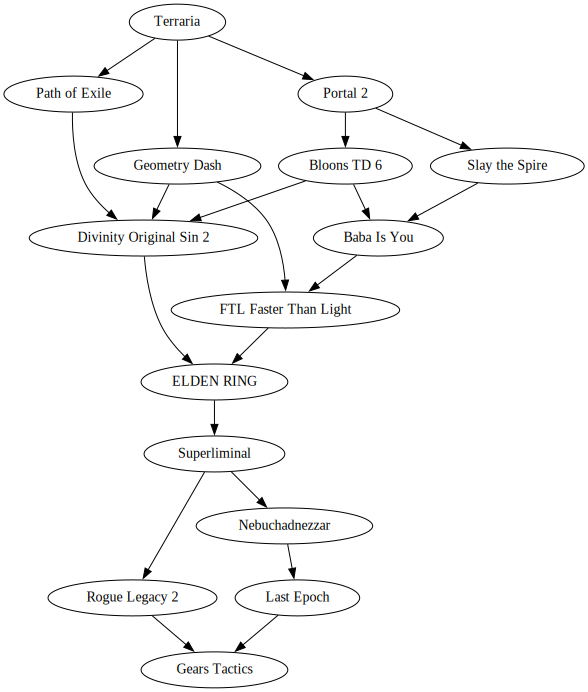

In [16]:
incomplete_ranking_to_graph(*PROMETHEE1_ranking(alternatives, criteria))

In [17]:
def PROMETHEE2_ranking(alternatives: pd.DataFrame, criteria: pd.DataFrame) -> graphviz.Digraph:
    ranking = sorted([(a[1][0], 
                       positive_flow(a, alternatives, criteria)-negative_flow(a, alternatives, criteria))
                       for a in alternatives.iterrows()], 
                       key = lambda x: x[1], reverse=True)
    ranking = [(name, round(score, 2)) for (name, score) in ranking]
    ranking_graph = graphviz.Digraph(comment="PROMETHEE II ranking")
    ranking_graph.node(ranking[0][0], ranking[0][0])
    previous_pair = ranking[0]
    for pair in ranking[1:]:
        ranking_graph.node(pair[0], pair[0])
        ranking_graph.edge(previous_pair[0], pair[0])
        previous_pair = pair
    return ranking_graph

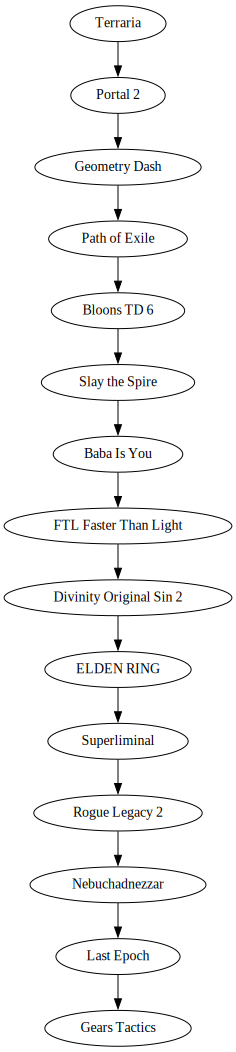

In [18]:
PROMETHEE2_ranking(alternatives, criteria)

## ELECTRE TRI-B

(reuses some variables and functions defined for PROMETHEE)

In [19]:
boundaries = pd.read_csv("./data/etrib_boundaries.csv")

In [20]:
boundaries

,title,price,positive_reviews_percentage,number_of_reviews,system_requirements,content_volume,gameplay,audio,graphics,wishlist_position
0,Top Tier,0,95,100000,1,5,8,8,8,2
1,High Tier,20,85,50000,3,4,7,5,5,4
2,Mid Tier,50,70,10000,5,3,5,4,4,6
3,Low Tier,100,50,1000,7,2,3,2,2,8
4,Bottom Tier,200,0,0,9,1,1,1,1,10


In [21]:
# Compute marginal concordance between alternative a and boundary b
def marginal_concordance_index(a: pd.Series, b: pd.Series, criterion: pd.Series) -> float:
    p = criterion["preference"]
    q = criterion["indifference"]
    criterion_type = criterion["criterion_type"]
    criterion_name = criterion["criterion_name"]
    a_val = a[criterion_name]
    b_val = b[criterion_name]
    difference = a_val - b_val
    if criterion_type == "cost":
        difference *= -1

    if difference >= -q:
        return 1
    if difference < -p:
        return 0
    return (difference + p) / (p - q)

# Compute marginal discordance between alternative a and boundary b
def marginal_discordance_index(a: pd.Series, b: pd.Series, criterion: pd.Series) -> float:
    v = criterion["veto"]
    p = criterion["preference"]
    criterion_type = criterion["criterion_type"]
    criterion_name = criterion["criterion_name"]
    a_val = a[criterion_name]
    b_val = b[criterion_name]
    difference = a_val - b_val
    if criterion_type == "cost":
        difference *= -1

    if difference <= -v:
        return 1
    if difference >= -p:
        return 0
    return (difference + p) / (p - v)

In [22]:
# Computes weights using the Simos-Roy-Figueira procedure
# Input: - a list of criteria (pd.Series) or blank cards (any other type) in DECREASING order of importance.
#          Thus, the first (highest) item of the list is expected to be a criterion.
#        - ratio Z (desired difference between the lowest and highest criterion weights)
# Output: pd.DataFrame with all criteria and an added "weight" attribute denoting its weight
#         (if a "weight" attribute already existed, it is in-place overwritten!)
def SRF(l: list, ratio) -> pd.DataFrame:
    criteria = pd.DataFrame([x for x in l if type(x) is pd.Series])
    criteria = criteria.assign(weight=[0]*len(criteria))
    
    # Very inefficient method, but simple and works
    passed = set()
    for item in l:
        if type(item) is pd.Series:
            passed.add(item['criterion_name'])
        for name in passed:
            criteria.loc[criteria['criterion_name'] == name, 'weight'] += 1
    
    # Ranked to non-normalized
    highest = criteria.iloc[0]['weight']
    criteria = criteria.assign(weight=1 + (ratio - 1) * (criteria['weight'] - 1) / (highest - 1))
    
    # Normalize and return
    total = sum(criteria['weight'])
    return criteria.assign(weight=criteria['weight'] / total)

In [23]:
# Compute comprehensive concordance index between alternative a and boundary b
def comprehensive_concordance_index(a: pd.Series, b: pd.Series, criteria: pd.DataFrame) -> float:
    numerator_sum = sum([marginal_concordance_index(a, b, criterion[1]) * criterion[1]["weight"] for criterion in criteria.iterrows()])
    sum_of_weights = sum([criterion[1]["weight"] for criterion in criteria.iterrows()])
    return numerator_sum/sum_of_weights

In [24]:
def outranking_credibility(a: pd.Series, b: pd.Series, criteria: pd.DataFrame) -> float:
    c = comprehensive_concordance_index(a, b, criteria)
    ret = c
    for _, criterion in criteria.iterrows():
        d = marginal_discordance_index(a, b, criterion)
        if d == 1:
            return 0 # small optimization
        if d > c:
            ret *= (1 - d) / (1 - c)
    return ret

In [25]:
# Compute "crisp" outranking relation between alternative a and boundary b
def crisp_outranking(a: pd.Series, b: pd.Series, criteria: pd.DataFrame, cutoff=0.65) -> str:
    aSb = outranking_credibility(a, b, criteria) >= cutoff
    bSa = outranking_credibility(b, a, criteria) >= cutoff
    if aSb and bSa:
        return '|'
    if not aSb and bSa:
        return '<'
    if aSb and not bSa:
        return '>'
    return '?'

In [26]:
# Pessimistically assigns alternative a to one of the boundaries based on criteria and cutoff
# Note: boundaries must be ordered from best to worst!
def assign_pes(a: pd.Series, boundaries: pd.DataFrame, criteria: pd.DataFrame, cutoff=0.65) -> pd.Series:
    last_b = boundaries.iloc[0]
    for _, b in boundaries.iterrows():
        if crisp_outranking(a, b, criteria) in '>|':
            return last_b
        last_b = b
    return boundaries.iloc[-1]

# Optimistically assigns alternative a to one of the boundaries based on criteria and cutoff
# Note: boundaries must be ordered from best to worst!
def assign_opt(a: pd.Series, boundaries: pd.DataFrame, criteria: pd.DataFrame, cutoff=0.65) -> pd.Series:
    last_b = boundaries.iloc[-1]
    for _, b in boundaries[::-1].iterrows():
        if crisp_outranking(a, b, criteria) in '<':
            return last_b
        last_b = b
    return boundaries.iloc[0]

In [27]:
# Run Electre TRI-B.
# Returns a dictionary that maps boundary titles to sets of assigned alternatives' titles
def ELECTRE_TRIB_sort(alternatives: pd.DataFrame, boundaries: pd.DataFrame, criteria: pd.DataFrame, assign_func: Callable, cutoff=0.65) -> dict:
    ret = {}
    for bname in boundaries['title']:
        ret[bname] = set()
    for _, a in alternatives.iterrows():
        b = assign_func(a, boundaries, criteria, cutoff)
        ret[b['title']].add(a['title'])
    return ret

In [28]:
for group, members in ELECTRE_TRIB_sort(alternatives, boundaries, criteria, assign_pes).items():
    print(f'{group} ({len(members)}):')
    for a in members:
        print(f'    {a}')

Top Tier (7):
    Baba Is You
    Bloons TD 6
    Portal 2
    Path of Exile
    Geometry Dash
    Terraria
    FTL Faster Than Light
High Tier (3):
    Superliminal
    Slay the Spire
    Nebuchadnezzar
Mid Tier (2):
    Gears Tactics
    Rogue Legacy 2
Low Tier (2):
    Divinity Original Sin 2
    Last Epoch
Bottom Tier (1):
    ELDEN RING


In [29]:
for group, members in ELECTRE_TRIB_sort(alternatives, boundaries, criteria, assign_opt).items():
    print(f'{group} ({len(members)}):')
    for a in members:
        print(f'    {a}')

Top Tier (7):
    Bloons TD 6
    Portal 2
    ELDEN RING
    Path of Exile
    Geometry Dash
    Terraria
    FTL Faster Than Light
High Tier (3):
    Divinity Original Sin 2
    Baba Is You
    Slay the Spire
Mid Tier (3):
    Last Epoch
    Superliminal
    Nebuchadnezzar
Low Tier (2):
    Gears Tactics
    Rogue Legacy 2
Bottom Tier (0):
